In [1]:
import re
import nltk
import pandas as pd
from gensim.models import Phrases
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

In [2]:
# nltk.download('punkt')                       # for tokenization
# nltk.download('wordnet')                     # for lemmatizer
# nltk.download('averaged_perceptron_tagger')  # for POS tagging
# nltk.download('stopwords')                   # for stop words

In [3]:
def load_data(filename):
    data = pd.read_json(filename)
    x = []
    for i in range(data.shape[0]):
        x.append(data.iloc[i]['catalog']['text'])
    return x

# Preprocessing

1. Tokenization
2. Stopwords and punctuation removal
3. POS tagging
4. Lemmatization
5. Uniting bigrams

In [4]:
data = load_data('data_bbc.json')
for sent in range(len(data)):
    data[sent] = nltk.word_tokenize(data[sent])
    for word in range(len(data[sent])):
        if data[sent][word].startswith("'"):
            data[sent][word] = data[sent][word][1:].lower()
        elif data[sent][word].endswith("'"):
            data[sent][word] = data[sent][word][:1].lower()
        else:
            data[sent][word] = data[sent][word].lower()

stop_words = set(stopwords.words('english'))
punctuation = ('…', '“', ';', '-', '!', '+', '’', '‘', '?',
               '—', '/', 'Ó', '”', '[', '@', '$', ')', '&',
               '%', ']', ':', '•', "'", '#', '=', '–', '(',
              ',', '.', '``', '', "n't")
data = [[word for word in sent if word not in stop_words and word not in punctuation] for sent in data]

In [5]:
def simplify_pos_tag(sent):
    tag_map = {
        "NN": "n", "NNS": "n", "NNP": "n", "NNPS": "n",
        "VB": "v", "VBD": "v", "VBG": "v", "VBN": "v",
        "VBP": "v", "VBZ": "v", "JJ": "a", "JJR": "a",
        "JJS": "a", "RB": "r", "RBR": "r", "RBS": "r",
        "DT": "s", "PRP$": "s", "POS": "s",
    }
    return [(word[0], tag_map[word[1]]) for word in sent if word[1] in tag_map]

In [6]:
lemmatizer = nltk.stem.WordNetLemmatizer()
bigram = Phrases(data)

for sent in range(len(data)):
    data[sent] = nltk.pos_tag(data[sent])
    data[sent] = simplify_pos_tag(data[sent])
    for word in range(len(data[sent])):
        data[sent][word] = lemmatizer.lemmatize(*data[sent][word])
    data[sent] = bigram[data[sent]]

# Models learning

In [7]:
from gensim.corpora import Dictionary
dictionary = Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

For evaluation I will use Topic Coherence (namely, C_v)

In [8]:
from gensim.models import CoherenceModel
import numpy as np
def compute_coherence(trained_model, texts, dictionar):
    cml = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionar, coherence='c_v')
    cur_val = cml.get_coherence()
    return cml, cur_val

First of all lets train LDA with standart hyperparameters and see the result:

In [10]:
ldamodel = LdaModel(corpus=corpus, id2word=dictionary)
cml_model, coherence_lda  = compute_coherence(ldamodel, data, dictionary)
print(coherence_lda)

0.36842639812014377


Now I will try to compute best values for hyperparameters  n_topics, alpha and beta (other parameters will be standart: chunksize=2000, passes=1, iterations=50)

In [19]:
results = []
alpha = list(np.arange(0.01, 1, 0.4))
alpha.append('symmetric')
alpha.append('asymmetric')
beta = list(np.arange(0.01, 1, 0.4))
beta.append('symmetric')

params_1 = {'num_topics': [2, 4, 6, 8, 10],
              'eval_every': [None]
         }
for num_topics in params_1['num_topics']:
    for a in alpha:
        for b in beta:
            for eval_every in params_1['eval_every']:
                    ldamodel = LdaModel(corpus=corpus, num_topics=num_topics, 
                                        id2word=dictionary, alpha=a, eta=b,
                                        eval_every=eval_every)
                    cml_model, coherence_lda = compute_coherence(ldamodel, data, dictionary)
                    results.append([num_topics, a, b, coherence_lda])

In [20]:
import pandas as pd
results = sorted(results, key=lambda x: x[3], reverse=True)
frame = pd.DataFrame(data=results, columns=['n_topics', 'alpha', 'beta', 'coherence'])
frame.to_excel('LDA_n_top_ab.xlsx')

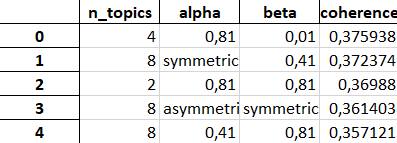
Full list of results is available in LDA_n_top_ab.xlsx

As we can see, the result is not even close to the one we are looking for. On standart parameters we had topic coherence 0.368, and after these computations the best that we have is 0.375. 

Now I will go over parameters chunksize, passes, eval_every. Since these hyperparameters will consume more computational power for a better prediction, consider the running time as well as the memory spent on the calculation, so that the selected parameters are optimal

In [22]:
import tracemalloc
from time import time

In [22]:
results_1 = []
for ee in range(5):
    for chunk in [500, 1000]:
        for p in [2, 5, 10, 15]:
            s = time()
            tracemalloc.start()
            
            ldamodel = LdaModel(corpus=corpus,
                id2word=dictionary, chunksize=chunk, 
                passes=p, eval_every=ee)
            
            curr, peak = tracemalloc.get_traced_memory()
            mem_usage_MB = (peak - curr) / 2 ** 20
            time_spent_min = (time() - s) / 60
            tracemalloc.reset_peak()
            
            cml_model, coherence_lda = compute_coherence(ldamodel, data, dictionary)
            results_1.append([ee, chunk, p, time_spent_min, mem_usage_MB, coherence_lda])

In [23]:
results_1 = sorted(results_1, key=lambda x: x[5], reverse=True)
frame = pd.DataFrame(data=results_1, columns=['eval_every', 'chunksize', 'passes', 'time (min)', 'memory (MB)', 'coherence'])
frame.to_excel('LDA_ee_c_p.xlsx')

In [9]:
exp_data = pd.read_excel('LDA_ee_c_p.xlsx')
exp_data.drop('Unnamed: 0', axis=1, inplace=True)
exp_data.head(10)

,eval_every,chunksize,passes,time (min),memory (MB),coherence
0,2,1000,15,9.193106,233.511782,0.458809
1,1,1000,15,11.920196,225.414974,0.453339
2,4,1000,10,5.724434,223.655816,0.451113
3,4,1000,15,8.524152,236.260625,0.446750
4,0,1000,15,4.950586,223.479608,0.445859
5,3,1000,15,8.382650,223.993709,0.444616
6,0,1000,10,3.820770,235.982119,0.442640
7,1,1000,10,8.531108,224.247204,0.438205
8,3,1000,10,5.461612,224.689418,0.431267
9,4,1000,5,3.400053,224.093704,0.431173


There is a significant increase in running time and memory, but also in coherence. Let's look at the graph and try to choose good parameters


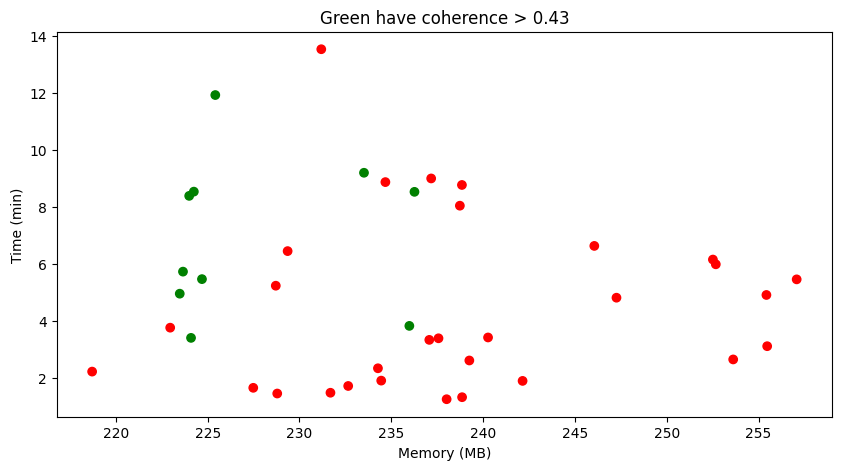

In [14]:
import matplotlib.pyplot as plt
color = ['g' if i > 0.43 else 'r' for i in exp_data['coherence']]
plt.figure(figsize=(10, 5))
plt.scatter(exp_data['memory (MB)'], exp_data['time (min)'], c=color)
plt.title('Green have coherence > 0.43')
plt.xlabel('Memory (MB)')
plt.ylabel('Time (min)')
plt.show()

Easy to notice that the best models consume less memory than others. So let's have a look at models that spent less than 225MB:

In [19]:
exp_data.loc[(exp_data['memory (MB)'] <= 225) & (exp_data['coherence'] > 0.43)]

,eval_every,chunksize,passes,time (min),memory (MB),coherence
2,4,1000,10,5.724434,223.655816,0.451113
4,0,1000,15,4.950586,223.479608,0.445859
5,3,1000,15,8.382650,223.993709,0.444616
7,1,1000,10,8.531108,224.247204,0.438205
8,3,1000,10,5.461612,224.689418,0.431267
9,4,1000,5,3.400053,224.093704,0.431173


Here I will choose optimal values for eval_every, chunksize, passes - 4, 1000, 10 respectively. Because the model with these parameters is average in terms of speed, in terms of memory consumption is in 2nd place (considering that space is higher the lower the memory consumption), and its accuracy is superior to all others.

Let's see if we can now improve this model with the hyperparameters n_topics, alpha, beta. Since the standard value of n_topics = 100, I will take values much smaller to reduce running time and memory consumption. Moreover, I don't need so many topics from the texts

In [23]:
results = []
alpha = list(np.arange(0.01, 1, 0.4))
alpha.append('symmetric')
alpha.append('asymmetric')
beta = list(np.arange(0.01, 1, 0.4))
beta.append('symmetric')

for num_topics in [2, 4, 6, 8, 10]:
    for a in alpha:
        for b in beta:
            s = time()
            tracemalloc.start()
            
            ldamodel = LdaModel(corpus=corpus, id2word=dictionary,
                                num_topics=num_topics, alpha=a, eta=b,
                                chunksize=1000,  passes=10, eval_every=4)
            
            curr, peak = tracemalloc.get_traced_memory()
            mem_usage_MB = (peak - curr) / 2 ** 20
            time_spent_min = (time() - s) / 60

            cml_model, coherence_lda = compute_coherence(ldamodel, data, dictionary)
            results.append([num_topics, a, b, time_spent_min, mem_usage_MB, coherence_lda])

In [24]:
results = sorted(results, key=lambda x: x[5], reverse=True)
frame = pd.DataFrame(data=results, columns=['num_topics', 'alpha', 'beta', 'time (min)', 'memory (MB)', 'coherence'])
frame.to_excel('LDA_finale.xlsx')

In [25]:
frame.head(10)

,num_topics,alpha,beta,time (min),memory (MB),coherence
0,8,symmetric,0.41,2.864762,79.013282,0.391089
1,4,asymmetric,0.01,2.069602,76.512909,0.372227
2,10,symmetric,0.01,2.177057,80.259904,0.369858
3,10,0.01,symmetric,2.069789,79.505193,0.366188
4,10,0.01,0.81,2.019345,79.517884,0.362390
5,10,symmetric,symmetric,1.923024,80.235443,0.360114
6,8,0.81,0.81,3.331784,78.916610,0.359997
7,8,0.41,symmetric,1.982722,78.748049,0.359829
8,6,asymmetric,0.81,1.837067,77.326608,0.359681
9,6,0.41,0.81,1.902210,77.116740,0.358897


Coherence worsened, but memory and time consumption decreased greatly. This is understandable, since the final coherence is counted as an average between all topics, and for each topic it is calculated based on the consistency of words in one topic with each other. Thus, the more topics the model calculates, the more likely it is that there will be more well matched topics among them.

In this work it was decided to choose the final parameters:

- num_topics = 8 
- alpha = symmetric 
- beta = 0.41 
- chunksize = 1000 
- passes = 10 
- eval_every = 4

Although topic coherence decreased by 0.06, we were able to reduce training time from 5.7 minutes to 2.8 minutes and memory cost from 223.65 MB to 79 MB.

In [26]:
model = ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, 
                            alpha='symmetric', eta=0.41, chunksize=1000, 
                            passes=10, eval_every=4)

In [27]:
model.show_topics()

[(0,
  '0.025*"say" + 0.010*"government" + 0.008*"rate" + 0.008*"uk" + 0.008*"tax" + 0.008*"rise" + 0.008*"also" + 0.008*"year" + 0.007*"people" + 0.007*"high"'),
 (1,
  '0.033*"say" + 0.007*"make" + 0.006*"also" + 0.006*"government" + 0.005*"new" + 0.005*"year" + 0.005*"people" + 0.005*"soldier" + 0.005*"ukraine" + 0.004*"home"'),
 (2,
  '0.027*"say" + 0.008*"year" + 0.006*"climate_change" + 0.006*"uk" + 0.006*"find" + 0.006*"specie" + 0.005*"people" + 0.005*"see" + 0.005*"add" + 0.005*"work"'),
 (3,
  '0.015*"say" + 0.008*"year" + 0.005*"country" + 0.004*"also" + 0.003*"take" + 0.003*"group" + 0.003*"election" + 0.003*"make" + 0.003*"become" + 0.003*"fossil_fuel"'),
 (4,
  '0.021*"say" + 0.005*"company" + 0.005*"people" + 0.004*"also" + 0.004*"year" + 0.004*"make" + 0.004*"take" + 0.004*"use" + 0.004*"time" + 0.004*"work"'),
 (5,
  '0.019*"year" + 0.015*"say" + 0.014*"uk" + 0.012*"record" + 0.009*"high" + 0.009*"also" + 0.008*"tree" + 0.008*"temperature" + 0.006*"meet" + 0.006*"last_

In [32]:
check_data = load_data('data_bbc.json')
check_data[0]

'More money is needed for flood prevention in order to prevent further devastation and cut clean-up costs, a council leader has said. Wales has been hit by disruption following days of continued heavy rain. Several flood warnings have been put in place and a weather warning for rain is in place until noon on Saturday. Andrew Morgan, leader of Rhondda Cynon Taf council, said "sustained investment" was needed as responding to flooding "drains" councils\' resources. The weather warnings cover the whole of Wales, while flood warnings are in effect in south and mid Wales. Flooding has led to between Cardiff and Bridgend county on Saturday, Transport for Wales said. Storms cause flooding, power cuts and train delays\nClear-up under way but more rain forecast Traffic Wales said the A470 between Llangurig to Rhayader in Powys had been closed due to flooding. On Thursday, homes lost power, people were rescued from cars and properties were damaged after persistent rain. Mr Morgan, who is also he

In [29]:
print(model.get_document_topics(corpus[0]))

[(0, 0.02662163), (4, 0.8072019), (5, 0.16458027)]


The model mostly refers the first article to topic 4. In general, this topic looks the most uninformative of all, because it contains mostly common words like 'say', 'take', 'make', 'also', 'use', so it is difficult for a person to assess the quality of such prediction. Let's try it on other articles:

In [45]:
for i in range(1, 10):
    print(sorted(model.get_document_topics(corpus[i]), key=lambda x: x[1], reverse=True))

[(4, 0.9979339)]
[(4, 0.9353376), (0, 0.06286784)]
[(4, 0.62693346), (7, 0.29621458), (5, 0.07488946)]
[(5, 0.49836323), (4, 0.47947502)]
[(4, 0.9810245), (6, 0.016922396)]
[(4, 0.6773992), (7, 0.24611217), (5, 0.07364751)]
[(3, 0.997794)]
[(2, 0.9979249)]
[(3, 0.9958884)]


In [46]:
check_data[8]  # article about chemicals in cosmetics

'Major beauty brands Urban Decay, Revolution and Inglot are selling make-up in the UK containing "forever chemicals", BBC News has found. These pollutants - known as PFAS - have been linked to serious health concerns including cancer. They are not illegal in the UK but five European countries are expected to propose an EU-wide ban on Friday. Urban Decay\'s owner L\'Oréal, Revolution and Inglot told the BBC they were phasing out the chemicals. PFAS, which stands for poly- and perfluoroalkyl substances, are resistant to oil and water, making them highly valuable to the make-up industry. Historically they have been added to products to make them last longer, improve finish and preserve the colour of eyeshadows and lipsticks. Many brands are now "PFAS-free" because of the increasing evidence of the negative environmental and health impacts from these compounds. But a BBC News investigation into the UK cosmetics market has identified dozens of products being sold in the UK still containing 

Apparently because of this "common" topic, the model relates most of the articles mainly to it, because each article contains many such common words. In terms of the accuracy of the model, this is of course good, because it is right in that each article contains many such "common" words, but in terms of the usefulness of such a model, of course, not so much. Because trying to get a brief summary of an article, for example, we will only get a bunch of common words and phrases.

But in spite of this, some articles it does a good job of defining not only to the 4 topic. For example 9 article which describes the BBC news investigation on the use of harmful chemicals in cosmetics, it is 0.997 accurate to topic 2 and it seems to be true, because this topic mentions 'uk', 'climate change', 'add', 'find'.